# Making a point source mask and then using it with Plancklens

## Steps

* Load a CMB temperature map, a point source map, a noise map, and make the sum
* Load a CMB power spectrum, a point source power spectrum, a noise power spectrum
* Apply a matched filter and check the mask
* Then, find the QE with and without mask case (you have to use the QE for mask)


In [1]:
import pathlib

import matplotlib.pyplot as plt

import numpy as np

import healpy as hp

from itfgs import foregrounds as fg


# Load a CMB temperature map, a point source map, a noise map, and make the sum

In [2]:
## First of all, we load the maps

directory = pathlib.Path("/Users/omard/Downloads/SCRATCHFOLDER/n32/S4WebskyWebskyBorn/cmbs/")
tname = "sim_0000_tlm.fits"

tmap_alm = hp.read_alm(directory / tname)

lmax = hp.Alm.getlmax(tmap_alm.shape[-1])

In [3]:
directory = pathlib.Path("/Users/omard/Downloads/SCRATCHFOLDER/SKYSIMS/WEBSKYSIMS/")
W = fg.WebSky(directory)

In [4]:
nu = 143

In [5]:
cib = W.cib(nu)
tsz = W.tsz(nu)
ksz = W.ksz()
radio = W.radio(nu)

In [6]:
cib_alm = hp.map2alm(cib, lmax = lmax)
tsz_alm = hp.map2alm(tsz, lmax = lmax)
ksz_alm = hp.map2alm(ksz, lmax = lmax)
radio_alm = hp.map2alm(radio, lmax = lmax)

In [7]:
from delensalot.sims.foregrounds import pointsources as ps

cond4mpi does not exists. No MPI loaded


In [8]:
F = ps.Foreground()

In [9]:
somma = tmap_alm+ksz_alm+tsz_alm+cib_alm+radio_alm

In [10]:
total_cl = hp.alm2cl(somma)
signal_cl = np.ones_like(total_cl)

clt = hp.alm2cl(tmap_alm)
clksz = hp.alm2cl(ksz_alm)
cltsz = hp.alm2cl(tsz_alm)
clcib = hp.alm2cl(cib_alm)
clradio = hp.alm2cl(radio_alm)


In [11]:
alms = hp.read_alm("/Users/omard/Downloads/SCRATCHFOLDER/SKYSIMS/WEBSKYSIMS/websky_radio_4096_143_alm.fits")
cla = hp.alm2cl(alms)

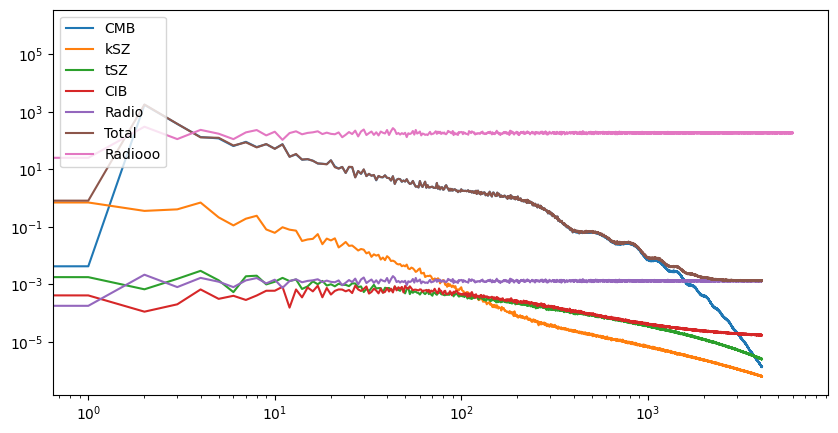

In [12]:
#plotting the power spectra

plt.figure(figsize = (10, 5))
plt.plot(clt, label = "CMB")
plt.plot(clksz, label = "kSZ")
plt.plot(cltsz, label = "tSZ")
plt.loglog(clcib, label = "CIB")
plt.loglog(clradio, label = "Radio")
plt.loglog(total_cl, label = "Total")
plt.loglog(cla, label = "Radiooo")
plt.legend()

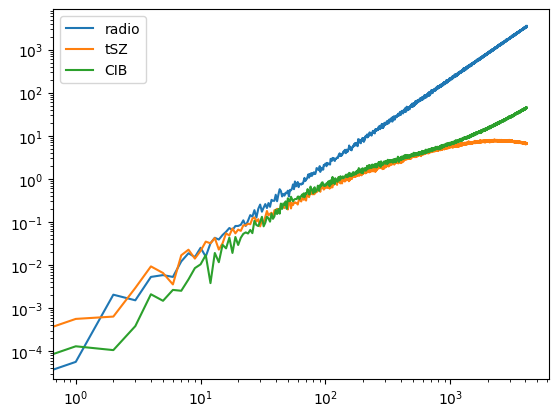

In [13]:
lb = np.arange(len(clt))
Dl_factor = lb * (lb + 1)/ (2*np.pi)
plt.loglog(Dl_factor*clradio, label = "radio")
plt.plot(Dl_factor*cltsz, label = "tSZ")
plt.loglog(Dl_factor*clcib, label = "CIB")
plt.legend()

In [14]:
nside = 2048
mf = F.matched_filter(input_map_alm = somma, total_cl = total_cl, signal_cl = signal_cl, nside = nside)

In [24]:
mask.shape

(50331648,)

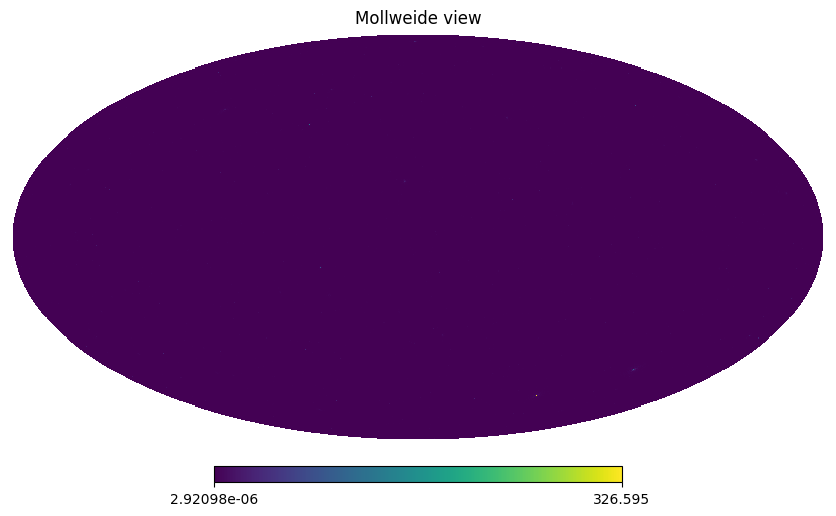

In [57]:
threshold = 5
SN_map = abs(mf) / np.std(mf)
mask =  np.where(SN_map > threshold, 0, 1)

hp.mollview(SN_map)

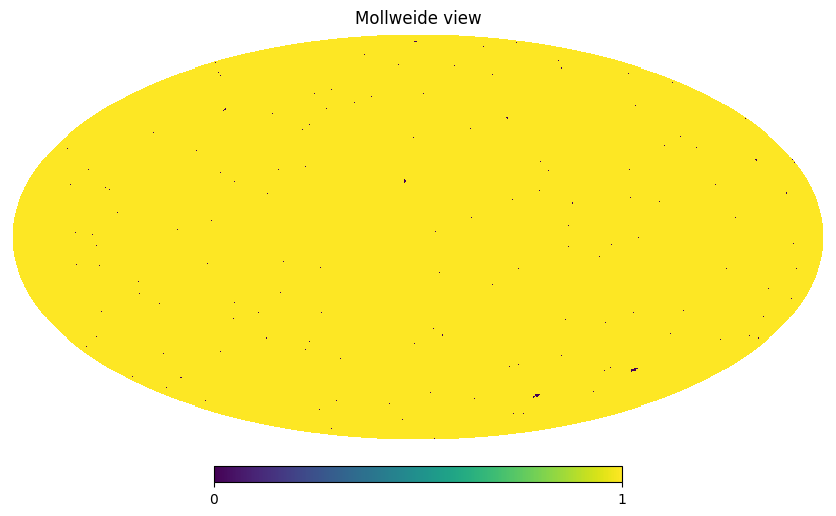

In [58]:
hp.mollview(mask)

In [59]:
positions = hp.pix2vec(nside, np.where(mask == 0))

In [70]:
radius = 4 #in arcmin
radius = np.radians(radius/60)

pixvalues = [hp.query_disc(nside, (a, b, c), radius) for a, b, c in zip(positions[0][0], positions[1][0], positions[2][0])]
pixvalues = np.unique(np.concatenate(pixvalues))

newmask = np.ones_like(mask)

for pix in pixvalues:
    newmask[pix] = 0

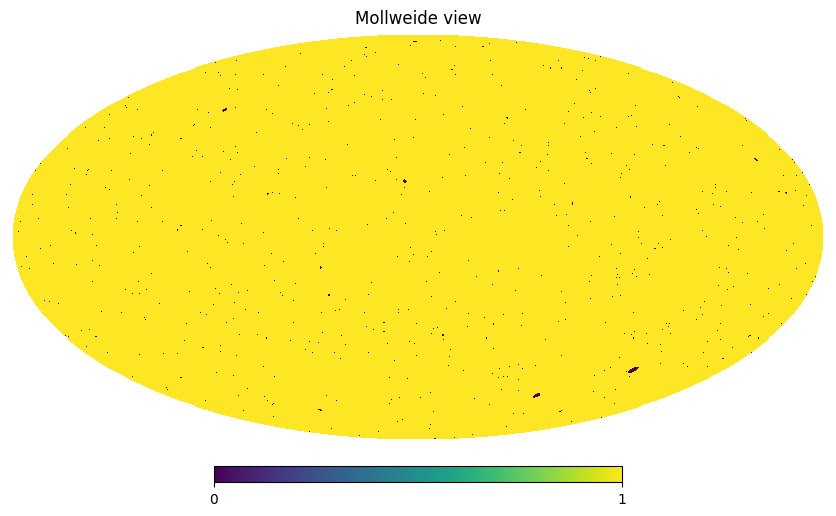

In [71]:
hp.mollview(newmask)

In [72]:
np.sum(newmask)/len(newmask)*100

99.70561861991882

In [73]:
np.sum(mask)/len(mask)*100

99.92367227872214

In [74]:
cib_down = hp.ud_grade(cib, nside_out = nside)
ksz_down = hp.ud_grade(ksz, nside_out = nside)

In [75]:
## Re-measure maps

masked_radio = radio * newmask
masked_cib = cib_down * newmask
masked_tsz = tsz * newmask
masked_ksz = ksz_down * newmask

In [76]:
masked_radio_alm = hp.map2alm(masked_radio, lmax = lmax)
masked_cib_alm = hp.map2alm(masked_cib, lmax = lmax)
masked_tsz_alm = hp.map2alm(masked_tsz, lmax = lmax)
masked_ksz_alm = hp.map2alm(masked_ksz, lmax = lmax)

In [77]:
masked_total_alm = masked_radio_alm + masked_cib_alm + masked_tsz_alm + masked_ksz_alm

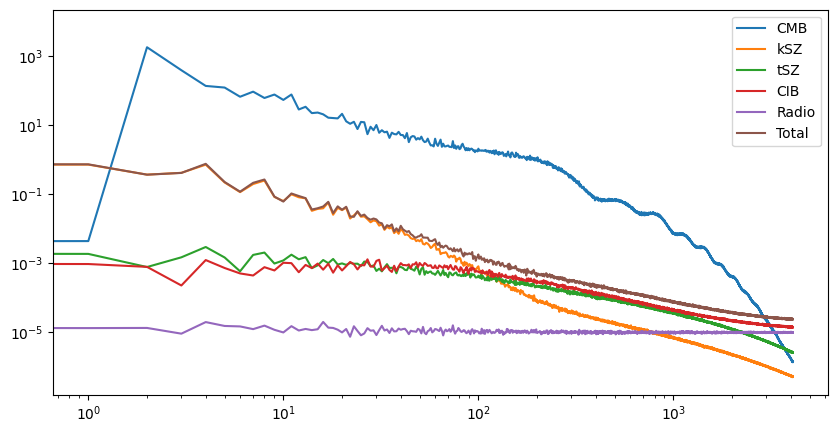

In [78]:
#plotting the masked power spectra

plt.figure(figsize = (10, 5))
plt.plot(clt, label = "CMB")
#masked ksz
plt.plot(hp.alm2cl(masked_ksz_alm), label = "kSZ")
#masked tsz
plt.plot(hp.alm2cl(masked_tsz_alm), label = "tSZ")
#masked cib
plt.loglog(hp.alm2cl(masked_cib_alm), label = "CIB")
#masked radio
plt.loglog(hp.alm2cl(masked_radio_alm), label = "Radio")
plt.loglog(hp.alm2cl(masked_total_alm), label = "Total")
plt.legend()


In [80]:
hp.write_map("mask_4arcmin_5sigma.fits", newmask, overwrite = True)

In [81]:
totfg = hp.alm2cl(masked_total_alm)
ls = np.arange(len(totfg))
np.savetxt("totfg_4arcmin_5sigma.txt", np.array([ls, totfg]).T)

## Run

Run several files with only one of the foregrounds